# interactive HALO tracks

This notebook shows how to plot the flight tracks of the HALO aircraft. First, we'll have only a quick look and later on we do some more work in order to get the data onto an interactive map.

## Preparations
First, we'll import pylab and the EUREC4A data catalog.

In [1]:
%pylab inline
import eurec4a
cat = eurec4a.get_intake_catalog()

Populating the interactive namespace from numpy and matplotlib


### Restructuring the dataset
When inspecting the contents of the currently available BAHAMAS quicklook dataset, we see that it does not handle coordinates according to the ideas of [CF conventions](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.html), which makes using the data a lot more difficult.

In [2]:
ds = cat.HALO.BAHAMAS.QL['HALO-0122'].to_dask()
ds

<xarray.Dataset>
Dimensions:    (tid: 331760)
Dimensions without coordinates: tid
Data variables: (12/46)
    TIME       (tid) datetime64[ns] ...
    IGI_RMSX   (tid) float32 ...
    IGI_RMSY   (tid) float32 ...
    IGI_RMSZ   (tid) float32 ...
    IRS_ALT    (tid) float32 ...
    IRS_ATA    (tid) float32 ...
    ...         ...
    TS         (tid) float32 ...
    RELHUM     (tid) float32 ...
    SOURCE     (tid) float32 ...
    WS         (tid) float32 ...
    MIXRATIOV  (tid) float32 ...
    MIXRATIO   (tid) float32 ...
Attributes: (12/20)
    title:                   Quality controlled data of DLR measurment flight...
    aircraft:                D-ADLR
    project:                 EUREC4A
    mission:                 EUREC4A
    ProjectInvestigator:     Stevens
    flightname:              adlr_20200122a
    ...                      ...
    TimeInterval:            14:57:36 - 24:10:32
    comment:                  Humidity is measured with SHARC and/or HUMICAP ...
    platform:                HALO
    instrument:              BAHAMAS
    Variablelist:             TIME IGI_RMSX IGI_RMSY IGI_RMSZ IRS_ALT IRS_ATA...
    EXTRA_DIMENSION.freqid:  10

In order to fix that a bit, we could come up with a little function which transforms the dataset we get into a dataset we would like to have. Of course the proper way of handling this would be to actually fix the dataset, but this way of doing it may still be illustrative.
Another advantage of this preparatory step is that amount of data in the dataset can be reduced, such that when we later load the datasets early, less data will be fetched.

In [3]:
def fix_halo_ql(ds):
    import xarray as xr
    ds = ds.rename({"tid":"time"})
    return xr.Dataset({
        "time": ds.TIME,
        "lat": ds.IRS_LAT,
        "lon": ds.IRS_LON,
        "alt": ds.IRS_ALT,
    })

This at least has a `time` coordinate.

In [4]:
dsfixed = fix_halo_ql(ds)
dsfixed

<xarray.Dataset>
Dimensions:  (time: 331760)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-22T14:57:36 ... 2020-01-23T00:10:3...
Data variables:
    lat      (time) float64 ...
    lon      (time) float64 ...
    alt      (time) float32 ...

Just to have a better visual impression, we can create a quick overview plot of the data:

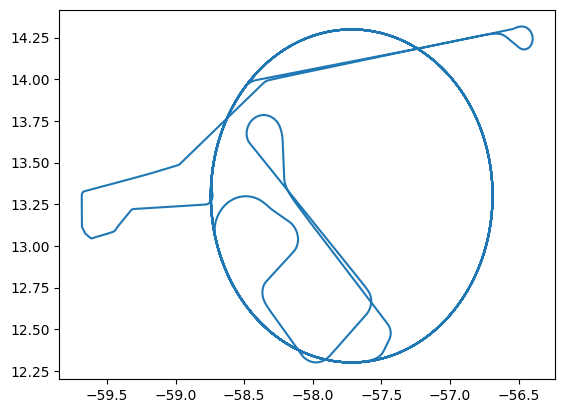

In [5]:
plt.plot(dsfixed.lon, dsfixed.lat)
plt.show()

### Reducing the size of the dataset

Later on, we want to plot all flights on an interactive map. Currently the dataset is rather large as the aircraft location has been recorded continuously at a high data rate. While this is good for quantitative analysis, this leads to poor interactive performance. So before going further, it is a good idea to reduce the amount of data while keeping the visual impression.

A possible idea to reduce the amount of required data is that plotting a line already does linear interpolation between two coordinate points. So if we would remove those points which are close to the linear interpolation between its neighboring points, the visual impression will stay almost the same. This idea has already been stated by Ramer Douglas and Peucker and is illustrated at [Wikipedia](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm). While the algorithm is not hard to write, it is difficult to do it efficiently in python. Thus, I've skipped it and use the [`simplification`](https://pypi.org/project/simplification/) library in stead.

```{note}
Many algorithms for shape processing are contained in the beautiful [shapely](https://shapely.readthedocs.io/en/stable/manual.html) library. In general, I'd recommend using that library, but it requies the GEOS library which is a bit tricky to install.
```

In [6]:
from simplification.cutil import simplify_coords_idx
def simplify_dataset(ds, tolerance):
    indices_to_take = simplify_coords_idx(np.stack([ds.lat.values, ds.lon.values], axis=1), tolerance)
    return ds.isel(time=indices_to_take)

We can now use that algorithm to generate a simplified version of the dataset with a tolerance of $10^{-5}$ degrees, which otherwise looks the same to the previous version.

In [7]:
dssimplified = simplify_dataset(dsfixed, 1e-5)
dssimplified

<xarray.Dataset>
Dimensions:  (time: 8225)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-22T14:57:36 ... 2020-01-23T00:10:3...
Data variables:
    lat      (time) float64 13.08 13.08 13.08 13.08 ... 13.07 13.07 13.07 13.07
    lon      (time) float64 -59.49 -59.48 -59.48 -59.47 ... -59.52 -59.51 -59.5
    alt      (time) float32 ...

We can now compare those two tracks side by side while keeping a look at the number of data points required.

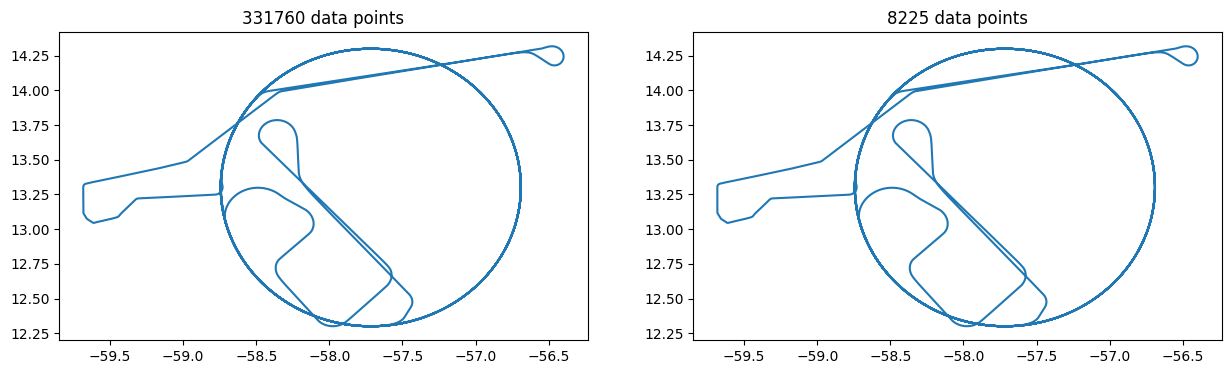

compression ratio: 2.48 %


In [8]:
fig, (ax1, ax2) = subplots(1, 2, figsize=(15,4))
ax1.plot(dsfixed.lon, dsfixed.lat)
ax1.set_title(f"{len(dsfixed.time)} data points")
ax2.plot(dssimplified.lon, dssimplified.lat)
ax2.set_title(f"{len(dssimplified.time)} data points")
plt.show()
ratio = len(dssimplified.time) / len(dsfixed.time)
print(f"compression ratio: {ratio*100:.2f} %")

The dataset size has been substantially reduced while the visual impression stayed the same.

## First interactive map

In order to show the map a little bit more interactively, we use the [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/index.html) library which creates a bridge between ipython and the [Leaflet](https://leafletjs.com/) JavaScript library.

In [9]:
import ipyleaflet

As we will need to convert many tracks to ipyleaflet layers later on, the easiest is to create a little function for that purpose right away:

In [10]:
def track2layer(track, color="green", name=""):
    return ipyleaflet.Polyline(
        locations=np.stack([track.lat.values, track.lon.values], axis=1).tolist(), 
        color=color,
        fill=False,
        weight=2,
        name=name
    )

With the help of that little function, creating a map is now like a breeze:

In [11]:
testmap = ipyleaflet.Map(center=(13.3, -57), zoom=7)
testmap.add_layer(track2layer(dssimplified))
display(testmap)

Map(center=[13.3, -57], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

## All in one
Let's see if we can add all the flights and provide a layer switcher so that we can have a look at all flights individually. We'll start by loading and simplifying all out track data into a local dictionary. Requesting the datasets from the server is IO bound and thus can simply be accellerated using a ThreadPool:

In [12]:
from multiprocessing.pool import ThreadPool
pool = ThreadPool(20)

def get_dataset(flight_id):
    ds = cat.HALO.BAHAMAS.QL[flight_id].to_dask()
    return flight_id, fix_halo_ql(ds).load()

full_tracks = dict(pool.map(get_dataset, cat.HALO.BAHAMAS.QL))

We still have to simplify the dataset, which is done here:

In [13]:
tracks = {flight_id: simplify_dataset(ds, 1e-5)
          for flight_id, ds in full_tracks.items()}

Let's also quickly grab some colors from a matplotlib colorbar, such that we can show all tracks in individual colors:

In [14]:
colors = [matplotlib.colors.to_hex(c)
          for c in plt.cm.inferno(np.linspace(0, 1, len(tracks)))]

We can now start with a new empty map. Let's also have a different [basemap](https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html).

In [15]:
m = ipyleaflet.Map(
    basemap=ipyleaflet.basemaps.Esri.NatGeoWorldMap,
    center=(13.3, -57), zoom=7
)

We'll add all the tracks as individual layers to the map

In [16]:
for (flight_id, track), color in zip(tracks.items(), colors):
    m.add_layer(track2layer(track, color, flight_id))

and add a scale, a legend, layer controls and a full screen button to the map and show it. If you want to zoom in, you can for example shift-click and drag a rectangle over the area you want to zoom in more closely.

In [17]:
m.add_control(ipyleaflet.ScaleControl(position='bottomleft'))
m.add_control(ipyleaflet.LegendControl(dict(zip(tracks, colors)),
                                       name="Flights",
                                       position="bottomright"))
m.add_control(ipyleaflet.LayersControl(position='topright'))
m.add_control(ipyleaflet.FullScreenControl())
display(m)

Map(center=[13.3, -57], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…